## Bibliotecas necesarias:

In [1]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import ndimage, datasets
import scipy.io

## Filtros no lineales: Filtros de Orden 

Considera un entorno de vecinos, incluido el pixel central. Se ordenan los valores y se elige, por ejemplo el primero (mínimo), el último (máximo) o el central (mediana). 

Dando lugar a:

- Filtro de mínimo, (suavisa y oscurece levemente)
- Filtro de máximo (suavisa y aclara levemente)
- **Filtro de mediana (suavisa y es robusto a valores extremos)**

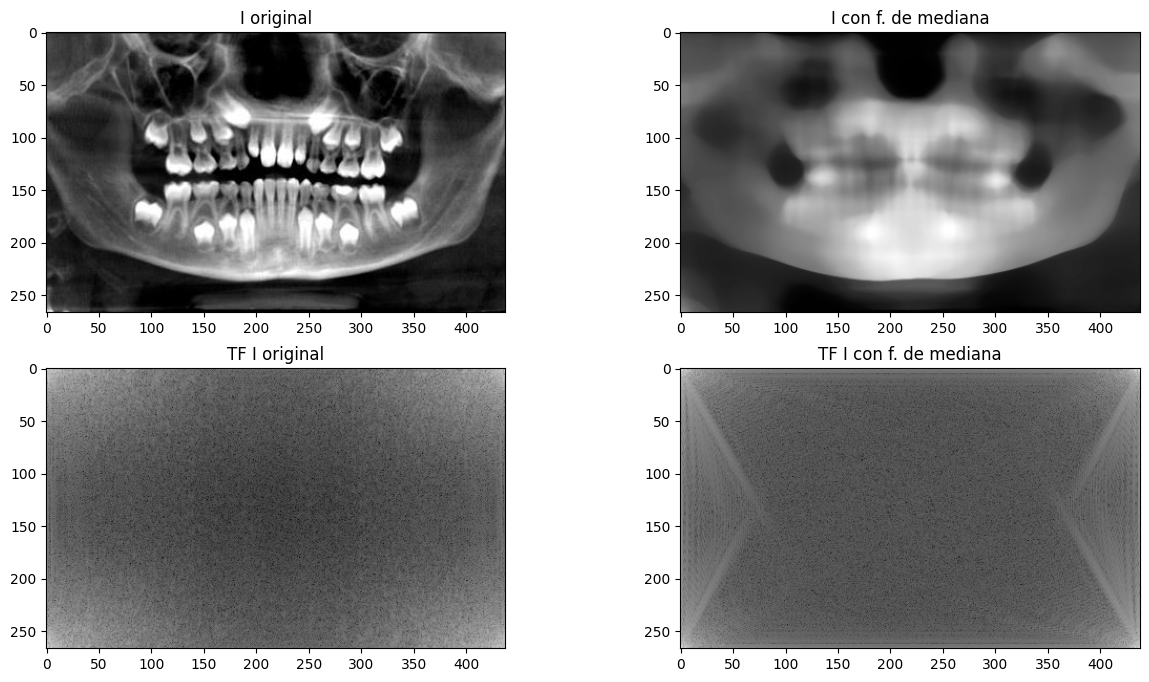

In [8]:
#filtro no lineal, por ejemplo filtro de mediana
n=39 #IMPAR mayor a 1
I=cv2.imread('Ortopantomografia.jpg',0) #abrimos imagen monocroma

I_M=cv2.medianBlur(I,n) #filtro de la mediana, ventana nxn  CUIDADO! es solo para tipo de dato CV_U8 (uint8)
# n => tamaño del kernel

fig = plt.gcf() #genero un elemento figura o traigo el último abierto
fig.set_size_inches(15, 8) #una nueva forma de definir dimensiones
plt.subplot(221)
plt.imshow(I,cmap='gray')
plt.title('I original')

plt.subplot(222)
plt.imshow(I_M,cmap='gray')
plt.title('I con f. de mediana')

# calculo la transformada de Fourier de la imagen
tf_I = np.fft.fft2(I)
tf_IM = np.fft.fft2(I_M)

# para plotear las transformadas de fourier uso escala en dB para que
# se vea mejor
plt.subplot(223)
plt.imshow(20*np.log(abs(tf_I)),cmap='gray')
plt.title('TF I original')

plt.subplot(224), plt.imshow(20*np.log(abs(tf_IM)),cmap='gray')
plt.title('TF I con f. de mediana')

plt.show()


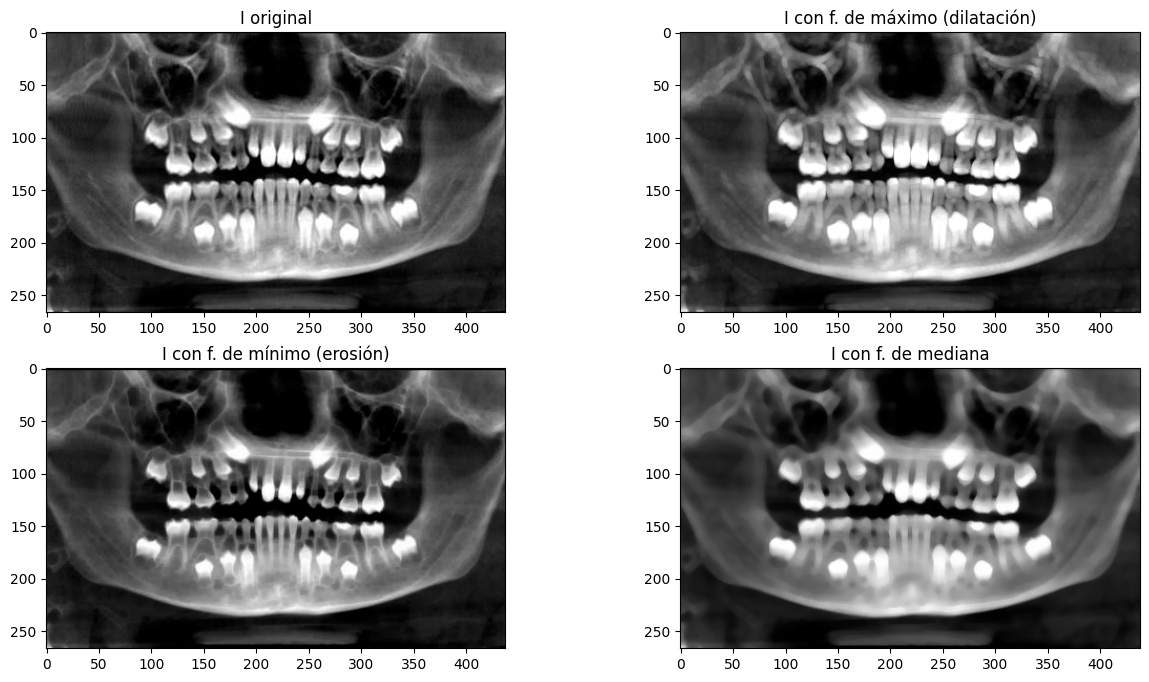

In [11]:
Imax = ndimage.maximum_filter(I, size=3, mode='nearest') #se puede usar con tipo de dato float64
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.maximum_filter.html

Imed = ndimage.median_filter(I, size=7) # filtro de mediana
Imin = ndimage.minimum_filter(I, size=3, mode='nearest') # filtro de minima
# size -> le digo de que tamaño tiene el kernel
# mode -> le digo que hacer cono los bordes
# nearest repite los de los costados

fig = plt.gcf() #genero un elemento figura o traigo el último abierto
fig.set_size_inches(15, 8) #una nueva forma de definir dimensiones
plt.subplot(221)
plt.imshow(I,cmap='gray')
plt.title('I original')

plt.subplot(222)
plt.imshow(Imax,cmap='gray')
plt.title('I con f. de máximo (dilatación)')#dilatación

plt.subplot(223)
plt.imshow(Imin,cmap='gray')
plt.title('I con f. de mínimo (erosión)') #erosión

plt.subplot(224)
plt.imshow(Imed,cmap='gray')
plt.title('I con f. de mediana')

plt.show()

# **Restauración de Imágenes**

## Imágenes corrompidas (por Ruido o Distorsión)

Podemos tener Imágenes afectadas con Ruido, con Distorsión o con ambas.
Abordaremos los dos primeros casos por separado:

- Imágenes con Ruido (aleatorio): $g(x,y)=f(x,y)+\eta(x,y)$
- Imágenes con Distorsión (sistemático): $g(x,y)=f(x,y)*h(x,y)$


Que hacer frente a una imagen corrompida?


1) Identificar cuál fue el proceso (Distorsión o Ruido y de que tipo)

2) Quitarlo de forma adecuada

### loadmat y loadtxt 

para archivos 'xxx.mat'y'xxx.txt' guardan o pueden guardar matrices (imágenes monocroma)

uint8 (256, 256)
uint8 (256, 256)
float64 (275, 275)


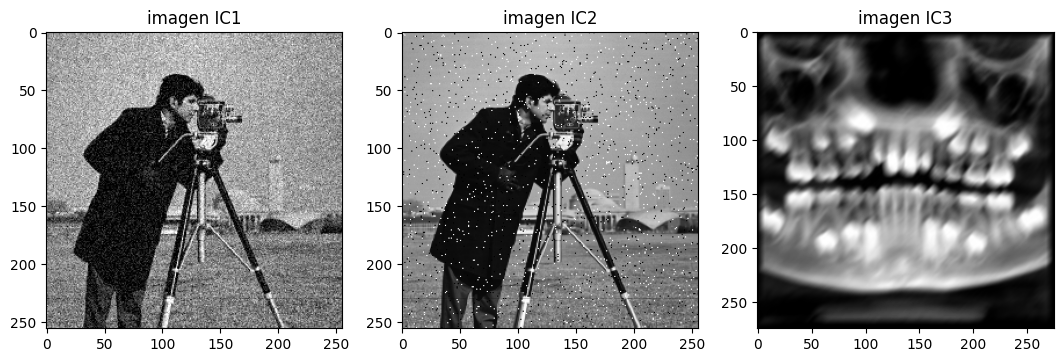

In [12]:
IC1_auxiliar = scipy.io.loadmat('IC1.mat')
IC1=IC1_auxiliar['IC1']

IC2_auxiliar = scipy.io.loadmat('IC2.mat')
IC2=IC2_auxiliar['IC2']

IC3 = np.loadtxt('IC3.txt')

print(IC2.dtype, IC1.shape)
print(IC2.dtype, IC2.shape)
print(IC3.dtype, IC3.shape)

plt.figure(figsize=(13,8))
plt.subplot(131)
plt.imshow(IC1,cmap='gray')
plt.title('imagen IC1') 

plt.subplot(132)
plt.imshow(IC2,cmap='gray')
plt.title('imagen IC2')

plt.subplot(133)
plt.imshow(IC3,cmap='gray')
plt.title('imagen IC3')

plt.show()

Que tipo de problema tiene cada una?


- IC1: ruido 
- IC2: ruido
- IC3: distorsion

Soluciones?

Soluciones generales (restauración) para cada tipo:

- Imágenes con Ruido -> filtros de suavizado (lineales y no lineales)
- Imágenes con Distorsión -> filtrado inverso (o deconvolución: $\widehat{F}(\omega_1,\omega_2)=G(\omega_1,\omega_2)/H(\omega_1,\omega_2)$




## Restauración por suavizado para quitar ruido


1) Necesitamos conocer o averiguar el tipo ruido. 

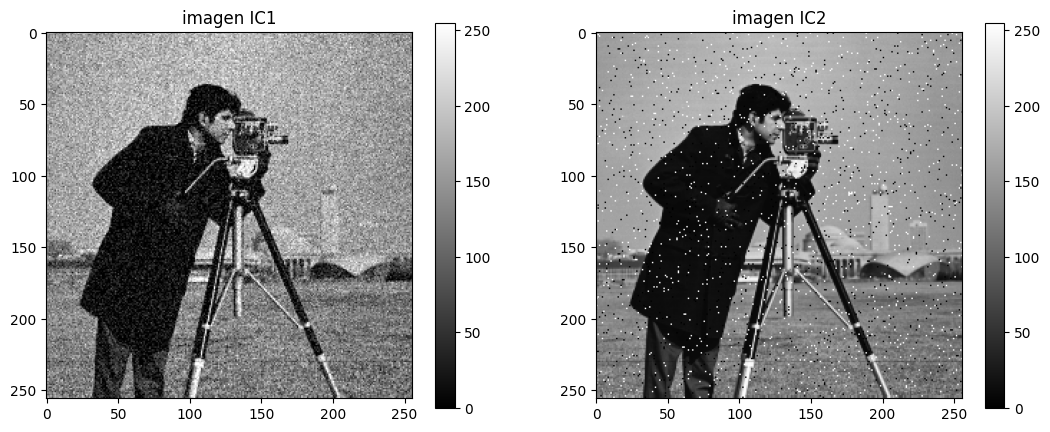

elegimos un recorte o región "homogénea" para calcular el histograma


In [13]:
plt.figure(figsize=(13,5))
plt.subplot(121)
plt.imshow(IC1,cmap='gray')
plt.title('imagen IC1')
plt.colorbar() 

plt.subplot(122)
plt.imshow(IC2,cmap='gray')
plt.title('imagen IC2')
plt.colorbar() 

plt.show()
print('elegimos un recorte o región "homogénea" para calcular el histograma')

## Tipo de Ruido

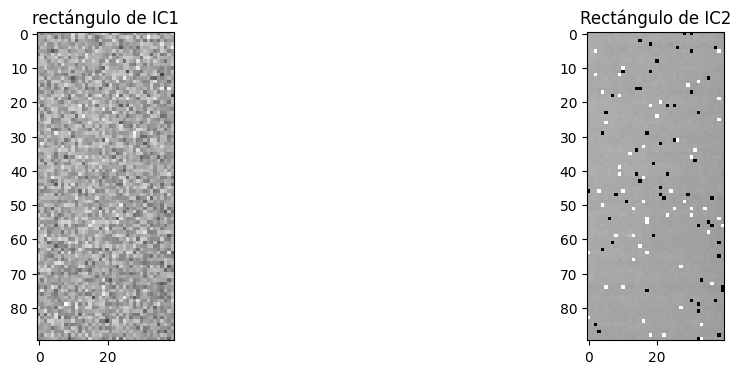

In [14]:
plt.figure(figsize=(13,4))

plt.subplot(121)
plt.imshow(IC1[10:100,180:220],vmin=0,vmax=255,cmap='gray')
plt.title('rectángulo de IC1') 

plt.subplot(122)
plt.imshow(IC2[10:100,180:220],vmin=0,vmax=255,cmap='gray')
plt.title('Rectángulo de IC2')

plt.show()

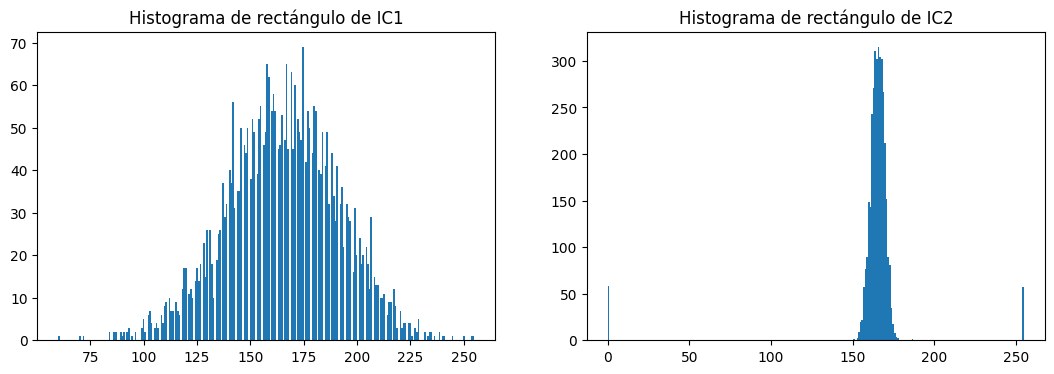

In [15]:
plt.figure(figsize=(13,4))

plt.subplot(121)
plt.hist(np.ravel(IC1[10:100,180:220]),bins=256)
plt.title('Histograma de rectángulo de IC1') 

plt.subplot(122)
plt.hist(np.ravel(IC2[10:100,180:220]),bins=256)
plt.title('Histograma de rectángulo de IC2')

plt.show()

Tipo de ruido?

- IC1: ruido gaussiano
- IC2: ruido sal & pimienta

2) Luego de identificar el tipo de ruido, se lo quitamos:

- si el ruido es Gaussiano-> suavisado, promediado, promediado gaussiano
- si el ruido es S& P-> mediana


In [16]:
#Definimos una función para generar una máscara o kernel cuadrado para promedio (suavizado)
def kernel_prom(n):
    return(np.ones((n,n),np.float32)/(n**2))

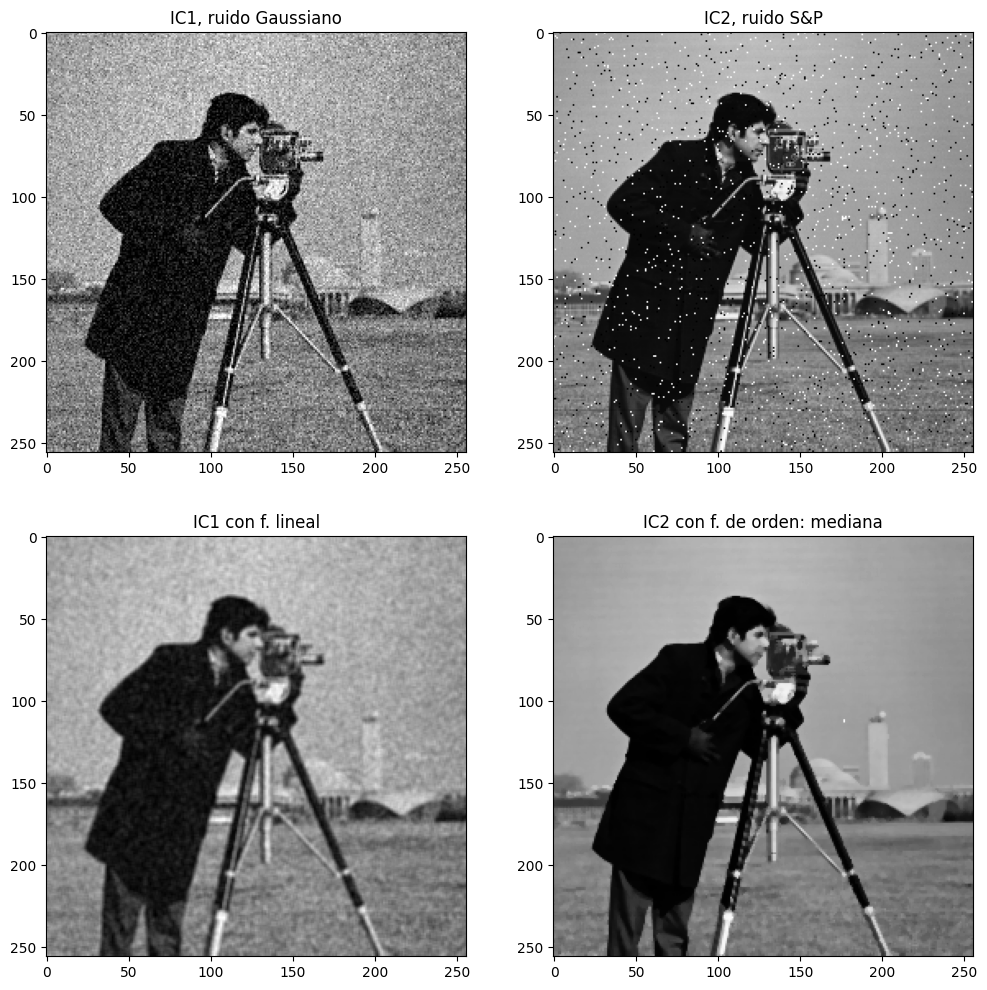

In [19]:
n=3
Kernel= kernel_prom(n) #Kernel para promediado, también puede ser promediado Gaussiano

#IC1_P=cv2.filter2D(IC1,-1, Kernel)  #filtro de suavizado lineal 
IC1_P=cv2.GaussianBlur(IC1,(n,n),2,2,0)  #filtro de suavizado lineal
IC2_M=cv2.medianBlur(IC2,n)  #filtro de mediana nxn #para tipo de dato CV_U8 (uint8)
#IC2_M=cv2.GaussianBlur(IC2,(n,n),2,2,0) #filtro de suavizado lineal 

plt.figure(figsize=(12,12))
plt.subplot(221), plt.imshow(IC1,cmap='gray'), plt.title('IC1, ruido Gaussiano')
plt.subplot(222), plt.imshow(IC2,cmap='gray'), plt.title('IC2, ruido S&P')

plt.subplot(223), plt.imshow(IC1_P,cmap='gray'), plt.title('IC1 con f. lineal')
plt.subplot(224), plt.imshow(IC2_M,cmap='gray'), plt.title('IC2 con f. de orden: mediana')
plt.show()


## Restauración por filtrado inverso para quitar distorsión

Que hacer frente a una imagen distorsionada (corrompida) por movimiento?



1) Necesitamos conocer o averiguar cual fue el movimiento o distorsión que sufrió. (y entender como funciona)

**Imágenes corrompidas por Distorsión:**

- $g(x,y)=f(x,y)*h(x,y)$

- Donde:
- $f$ imagen original y $h$ es el kernel de la distorsión, la más usual es la distorsión por movimiento


2) Una vez identificado $h$, se lo "quitaremos" por decolvolución o filtrado inverso (lo haremos en el dominio de la frecuencia)


https://www.geeksforgeeks.org/opencv-motion-blur-in-python/


### Distorsión por movimiento:

In [20]:
#función para generar kernel de movimiento
def motion_kernel(tam=3, ang=45): 
  c=tam//2 
  if tam%2==1: tamm=tam
  else: tamm=tam+1
  kernel=np.zeros((tamm,tamm))
  kernel[c,0:tam]=1/tam
  M = cv2.getRotationMatrix2D((c,c),ang,1)
  kernel = cv2.warpAffine(kernel,M,(tamm,tamm))
  return kernel


In [21]:
kernelM=motion_kernel(5,0) #cantidad de pixeles y ángulo del movimiento 
print(kernelM)

[[0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.2 0.2 0.2 0.2 0.2]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]]


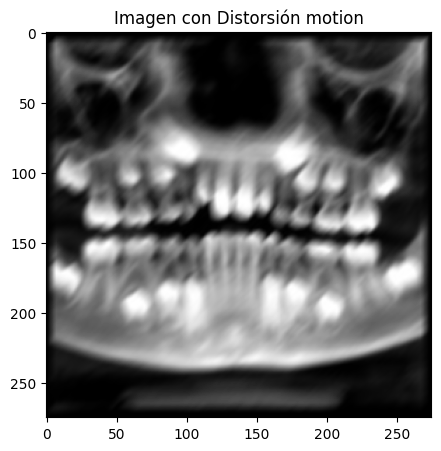

In [22]:
plt.figure(figsize=(13,5))

plt.imshow(IC3,cmap='gray')
plt.title('Imagen con Distorsión motion')

plt.show()

In [23]:
g=IC3.copy() #nuestra imagen Distorsionada


Por algún motivo.. Se sabe (o se sospecha... ) que la imagen IC3 es una imagen ditorsionada por un movimiento de 9 pixeles a 45º.

In [24]:
h1=motion_kernel(9,45) #kernel de la correlación que sufrió 
#luego se considera el kernel de la convolución (que sufrió): 
h=cv2.rotate(h1,cv2.ROTATE_180) #cv2.rotate p/ rotaciones múltiplos de 90

**No conocemos la Original $f$**, pero sabemos que $g$ fue el resultado de:



- $g(x,y)=f(x,y)*h(x,y)$, conv en el dominio espacial

- $G(\omega_1,\omega_2)=F(\omega_1,\omega_2).H(\omega_1,\omega_2)$, en el dominio de la frecuencia


Si la distorsión (o conv) es lo mismo que producto en el dominio de frecuencia, se la quitamos dividiendo... 

Restaurada en el dominio de la frecuencia:

$\widehat{F}(\omega_1,\omega_2)=G(\omega_1,\omega_2)/H(\omega_1,\omega_2)$

Luego volvemos al dominio espacial-> Imagen restaurada:

$\widehat{f}(x,y)=\mathcal{F}^{-1}(\widehat{F}(\omega_1,\omega_2))$


$\widehat{f}(x,y)=ifft(\widehat{F}(\omega_1,\omega_2))$ 

### Filtrado inverso (deconvolución)

**Restauraremos la imagen distorsionada (corrompida)**

Pasamos la imagen distorsionada al dominio de frecuencia

In [25]:
s1,s2 = g.shape[0],g.shape[1]
G=np.fft.fft2(g,(s1,s2))  #que teóricamente es lo mismo que el producto de las transformadas: TI*H

In [27]:
H=np.fft.fft2(h,(s1,s2)) #filtro h en frecuencia 

eps= np.finfo(float).eps  #2.220446049250313e-16, numero muuuuy chiquito pero distinto de cero ;)
# eps = epsilon -> me ayuda a no dividir por sero, pero es chiquito asi  que no modifica el dato
print(eps)
R_frec=G/(H+eps) # le "quitamos" el filtro/distorsión en frecuencia #usamos eps para evitar dividir por 0 pero casi no modificar demasiado la cuenta 

f_R=np.abs(np.fft.ifft2(R_frec)) #volvemos al dominio espacial

#Notar que en este bloque NO usamos la original, sólo la distorsionada y el filtro (hay que conocerlo)

2.220446049250313e-16


**Graficamos la restaurada:**

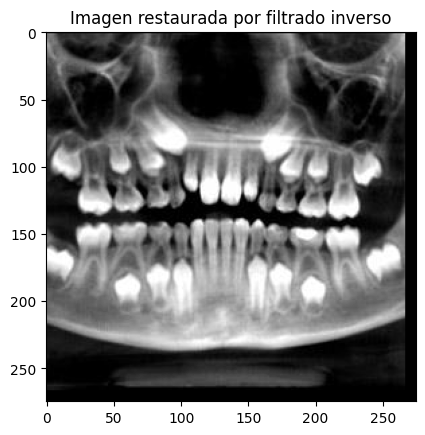

In [28]:
plt.imshow(f_R,cmap='gray')
plt.title('Imagen restaurada por filtrado inverso')
plt.show()

Notar las dimensiones y zero padding

### Distorsionamos nosotros

 y guardamos el archivo

In [29]:
I=cv2.imread('TS.jpg',0) #abrimos imagen monocroma
#I=cv2.imread('lung_disease.png', 0)


hm=motion_kernel(19,45) 
hmrot=cv2.rotate(hm,cv2.ROTATE_180) #cv2.rotate p/ rotaciones múltiplos de 90
#print(np.round(hrot,decimals=3))

#imagen corrompida/distorsionada con h: un movimiento de tamaño ? pixeles, en direción ? grados
ID=signal.convolve2d(I, hmrot, boundary='fill', fillvalue=0, mode='full') 
print('tamaño original:', I.shape,'tamaño kernel:', hmrot.shape, ' tamaño distorsionada:', ID.shape)
np.savetxt('ID.txt',ID)

tamaño original: (1024, 1024) tamaño kernel: (19, 19)  tamaño distorsionada: (1042, 1042)


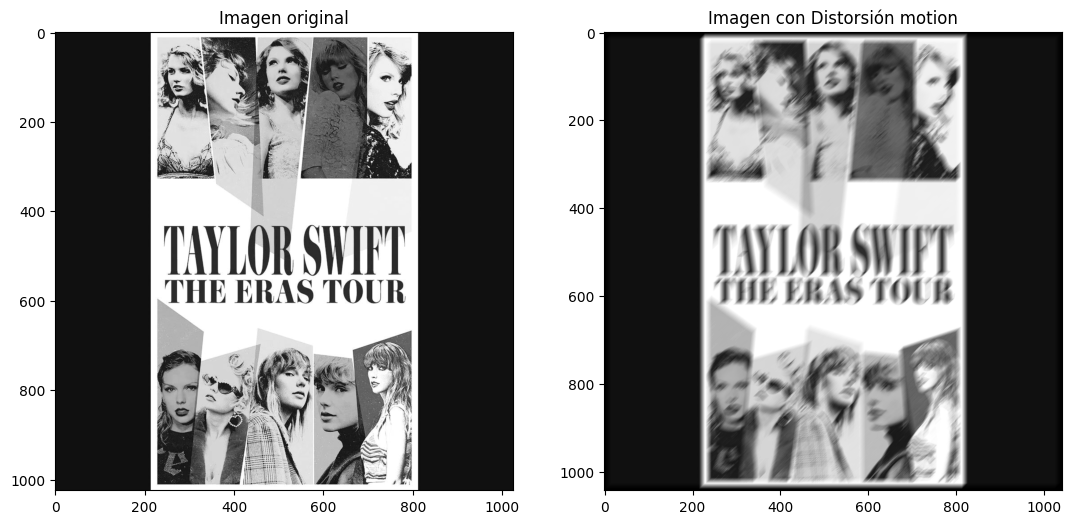

In [ ]:
plt.figure(figsize=(13,6))

plt.subplot(121)
plt.imshow(I,cmap='gray')
plt.title('Imagen original')	

plt.subplot(122)
plt.imshow(ID,cmap='gray')
plt.title('Imagen con Distorsión motion')

plt.show()

Para cuentas conviene usar float64

# <span style="background: red;">Ejercicio: Quitar la disporsión de ID</span>